In [1]:
pip install tflearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=a2e468250ec78deaa36c57de35d0a4e84393fcf03977c8a34a0e1b11fca7d07a
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import imageio
import os
from tqdm import tqdm
import cv2
import numpy as np
from skimage import filters
from keras.layers import Input,Dense,Flatten,Dropout,merge,Activation,LeakyReLU,Softmax
from tensorflow.keras.layers import BatchNormalization,Conv3D,MaxPool3D, AveragePooling3D
from keras.models import Model,Sequential,load_model
from tensorflow.keras.optimizers import Adam
from keras import activations
from keras import regularizers
import torch
import torchvision.transforms as transforms
#from vis.utils import utils
import SimpleITK as sitk
import tensorflow as tf
import tflearn
import nibabel as nib
#from keras.utils import to_categorical
#from vis.visualization import visualize_saliency, visualize_activation, visualize_cam
#import keras_vis.visualization
#import keras_vis as vis
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Load data

In [3]:
#File of input, MRI Images
image_path_CN="../input/300-reduced-adni-skull-stripped-labelled/newCN100"
image_path_MCI="../input/300-reduced-adni-skull-stripped-labelled/MCI"
image_path_AD="../input/300-reduced-adni-skull-stripped-labelled/newAD100"

# Append images with their correct labels

In [4]:
image_data=[]
label_data=[]

for m in tqdm(os.listdir(image_path_CN)):

    sitk_image_R= sitk.ReadImage(os.path.join(image_path_CN,m))
    sitk_image_array = sitk.GetArrayFromImage(sitk_image_R)
    sitk_image_array_transposed = np.transpose(sitk_image_array)
    sitk_image_array_transposed = sitk_image_array_transposed[...,np.newaxis]
    image_data.append(sitk_image_array_transposed)
    label_data.append("CN") #CN 
    

    
    
for m in tqdm(os.listdir(image_path_MCI)):
    sitk_image_R= sitk.ReadImage(os.path.join(image_path_MCI,m))
    sitk_image_array = sitk.GetArrayFromImage(sitk_image_R)
    sitk_image_array_transposed = np.transpose(sitk_image_array)
    sitk_image_array_transposed = sitk_image_array_transposed[...,np.newaxis]
    image_data.append(sitk_image_array_transposed)
    label_data.append("MCI")#MCI 


for m in tqdm(os.listdir(image_path_AD)):
    sitk_image_R= sitk.ReadImage(os.path.join(image_path_AD,m))
    sitk_image_array = sitk.GetArrayFromImage(sitk_image_R)
    sitk_image_array_transposed = np.transpose(sitk_image_array)
    sitk_image_array_transposed = sitk_image_array_transposed[...,np.newaxis]
    image_data.append(sitk_image_array_transposed)
    label_data.append("AD") #AD


image_data = np.array(image_data)
label_data = np.array(label_data)
unique, inverse = np.unique(label_data, return_inverse=True)
onehot = np.eye(unique.shape[0])[inverse]
print(label_data)
print(onehot)


img_shape = image_data.shape

100%|██████████| 96/96 [00:49<00:00,  1.94it/s]


['CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN'
 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN'
 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN'
 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN'
 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN'
 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN'
 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN'
 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI'
 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI'
 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI'
 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI'
 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI'
 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI'
 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 

# Split Images to train and validate


In [5]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_Y,valid_Y = train_test_split(image_data,onehot,test_size=0.2,stratify = onehot,random_state=19)
print(len(train_X))
print(len(valid_X))
print(len(train_Y))
print(len(valid_Y))

237
60
237
60


In [6]:
del image_data
del label_data
del onehot

# Building the Model 

In [7]:
batch_size = 30
epochs = 60

def get_model():
    model = Sequential()
   # model.add(Lambda (input_shape=(166,256,256,1))
    model.add(Conv3D(filters=16, kernel_size=(5,5,5), padding='valid', strides=(2,2,2),activation='leaky_relu',input_shape=(166,256,256,1), kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPool3D(pool_size=(2,2,2), strides=(2,2,2),padding='valid'))
    model.add(Conv3D(filters=32, kernel_size=(3,3,3), padding='valid', strides=(2,2,2),kernel_regularizer=regularizers.l2(0.01)))
    
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool3D(pool_size=(2,2,2), strides=(2,2,2),padding='valid'))
    model.add(Dropout(0.5))
    model.add(AveragePooling3D(pool_size=(2,2,2), strides=(2,2,2),padding='valid'))
    
#     model.add(Conv3D(filters=64, kernel_size=(3,3,3), padding='valid', strides=(1,1,1),activation='leaky_relu',kernel_regularizer=regularizers.l2(0.01)))
#     model.add(MaxPool3D(pool_size=(2,2,2), strides=(2,2,2),padding='valid'))
#     model.add(Conv3D(filters=128, kernel_size=(3,3,3), padding='valid', strides=(1,1,1),kernel_regularizer=regularizers.l2(0.01)))
    
#     model.add(BatchNormalization())
#     model.add(LeakyReLU())
#     model.add(MaxPool3D(pool_size=(2,2,2), strides=(2,2,2),padding='valid'))
#     model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(1024,kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.6))
    
    model.add(Dense(512,kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
    
    model.add(Dense(128,kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
    
    model.add(Dense(3,kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Softmax())
    
    return model

In [8]:
model = get_model()
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 81, 126, 126, 16)  2016      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 40, 63, 63, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 19, 31, 31, 32)    13856     
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 31, 31, 32)    128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 19, 31, 31, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 9, 15, 15, 32)     0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 15, 15, 32)     0

# Model Training 

In [9]:
model_train = model.fit(train_X, train_Y, batch_size = batch_size, epochs = epochs, verbose=1,validation_data=(valid_X, valid_Y))

Train on 237 samples, validate on 60 samples


2023-02-01 19:47:21.042267: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/60
237/237 [==============================] - ETA: 0s - loss: 25.9727 - acc: 0.2996

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


237/237 [==============================] - 68s 288ms/sample - loss: 25.9727 - acc: 0.2996 - val_loss: 31.0010 - val_acc: 0.2833
Epoch 2/60
237/237 [==============================] - 61s 259ms/sample - loss: 21.5489 - acc: 0.3755 - val_loss: 27.9073 - val_acc: 0.3500
Epoch 3/60
237/237 [==============================] - 61s 256ms/sample - loss: 17.8575 - acc: 0.4051 - val_loss: 24.6183 - val_acc: 0.3500
Epoch 4/60
237/237 [==============================] - 61s 256ms/sample - loss: 15.1604 - acc: 0.3924 - val_loss: 22.2899 - val_acc: 0.3000
Epoch 5/60
237/237 [==============================] - 61s 259ms/sample - loss: 13.0906 - acc: 0.3755 - val_loss: 19.7409 - val_acc: 0.3500
Epoch 6/60
237/237 [==============================] - 67s 282ms/sample - loss: 11.4577 - acc: 0.4388 - val_loss: 16.0564 - val_acc: 0.3500
Epoch 7/60
237/237 [==============================] - 61s 255ms/sample - loss: 10.0869 - acc: 0.4093 - val_loss: 12.9541 - val_acc: 0.3500
Epoch 8/60
237/237 [==================

# Visualizing of Training vs Validation Loss

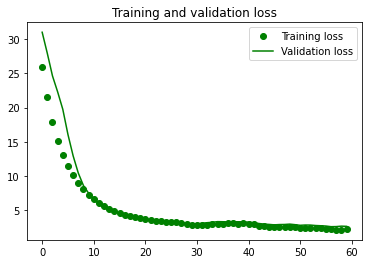

In [10]:
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(60)
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Visualizing of Training vs Validation Accuracy

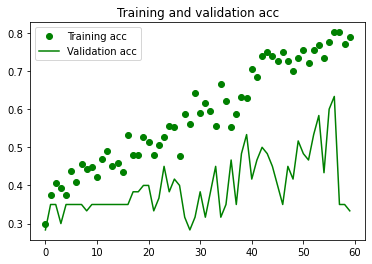

Mean training accuracy 0.586146 
Mean validation accuracy 0.398333


In [11]:
acc = model_train.history['acc']
val_acc = model_train.history['val_acc']
epochs = range(60)
plt.figure()
plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()
acc = np.asarray(acc).mean()
val_acc = np.asarray(val_acc).mean() 
print('Mean training accuracy %f ' % acc)
print('Mean validation accuracy %f' % val_acc)

# Model Prediction

In [12]:
pred = model.predict(valid_X) #return learning labels 
pred_label=np.argmax(pred,axis=1) 
actual_label=np.argmax(valid_Y,axis=1)
print(valid_Y)
print(actual_label)
print("--------------------------")
print(pred)
print(pred_label)
print(actual_label)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[2 1 1 0 2 0 1 2 1 2 1 1 1 2 1 0 0 0 0 2 2 1 0 1 0 0 2 0 2 0 0 0 1 2 2 2 2
 2 2 0 2 0 0 0 2 1 1 1 0 1 2 1 2 1 1 0 2 1 1 2]
--------------------------
[[0.27322686 0.20769805 0.51907504]
 [0.29381818 0.29864976 0.407532  ]
 [0.31474638 0.30652684 0.3787268 ]
 [0.33531132 0.324373

# Labelling

In [13]:
label_name=["AD","CN","MCI"]

# Confusion Matrix

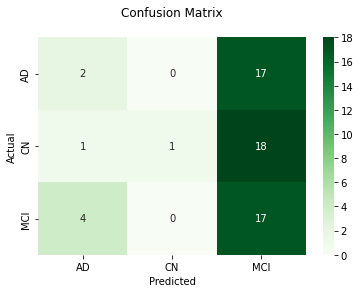

In [14]:
from sklearn.metrics import confusion_matrix
ConfusionMatrix = confusion_matrix(actual_label, pred_label)
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("Confusion Matrix\n")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Classification Report 

In [15]:
from sklearn.metrics import classification_report
print(classification_report(actual_label, pred_label, target_names=["AD","CN","MCI"]))

              precision    recall  f1-score   support

          AD       0.29      0.11      0.15        19
          CN       1.00      0.05      0.10        20
         MCI       0.33      0.81      0.47        21

    accuracy                           0.33        60
   macro avg       0.54      0.32      0.24        60
weighted avg       0.54      0.33      0.24        60



# Roc Curve

ROC for label  0


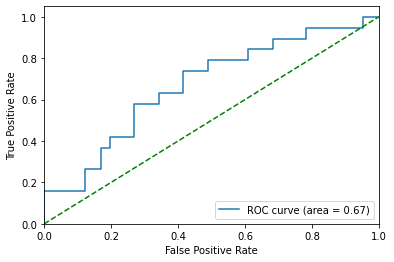

ROC for label  1


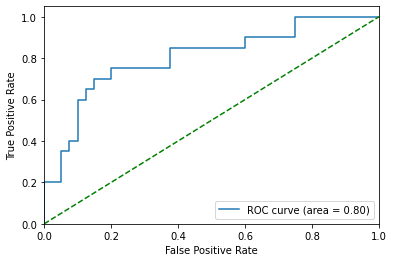

ROC for label  2


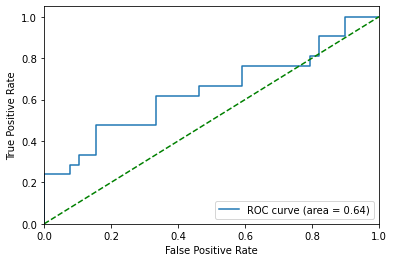

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(valid_Y[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
for i in range(3):
    print("ROC for label ",i)
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'g--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

# Probablities Testing 

In [17]:
def maxProbability(arr):
    array=arr[0]
    max = array[0]
    for i in range(1, 3):
        if array[i] > max:
            max = array[i]
    return max

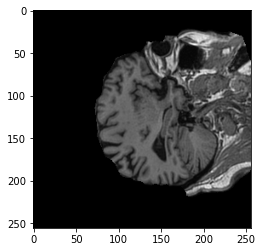

[[0.2732269  0.20769806 0.51907504]]
[2]
The actual label is 2
51.91 % chances are there that the image is MCI


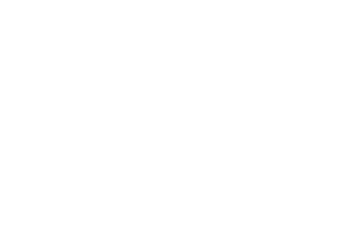

In [18]:
#TEST CASE 1
Test_image = valid_X[0]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
Result = model.predict(Test_image)
Result_label=np.argmax(Result,axis=1)
print(Result)
print(Result_label)
probability = round((maxProbability(model.predict(Test_image))*100),2)

print('The actual label is',actual_label[0])
if Result_label[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif Result_label[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif Result_label[0] == 2:
    print(probability, '% chances are there that the image is MCI')


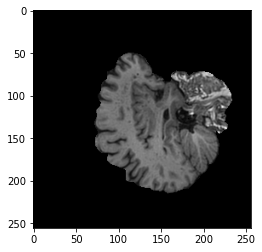

The actual label is 1
40.75 % chances are there that the image is MCI


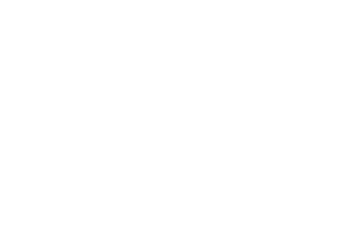

In [19]:
#TEST CASE 2
Test_image = valid_X[1]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
Result = model.predict(Test_image)
Result_label=np.argmax(Result,axis=1)
probability = round((maxProbability(model.predict(Test_image))*100),2)

print('The actual label is',actual_label[1])
if Result_label[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif Result_label[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif Result_label[0] == 2:
    print(probability, '% chances are there that the image is MCI')

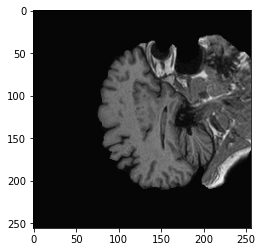

The actual label is 1
37.87 % chances are there that the image is MCI


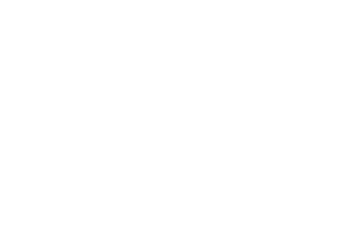

In [20]:
#TEST CASE 3
Test_image = valid_X[2]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
Result = model.predict(Test_image)
Result_label=np.argmax(Result,axis=1)
probability = round((maxProbability(model.predict(Test_image))*100),2)

print('The actual label is',actual_label[2])
if Result_label[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif Result_label[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif Result_label[0] == 2:
    print(probability, '% chances are there that the image is MCI')

# Grad Cam

In [21]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torchvision
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.transform import resize

In [22]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    #Give input to the model to get the output of the last conv layer and the predicted label
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [23]:
def save_and_display_gradcam(img_array, heatmap, alpha=0.4):
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize(256,256)
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img,cmap="gray")
    plt.show()

In [24]:
'''images_array_R=[]
image_path_test = "../input/adni-tissueseg-gm-labelled/AD_GM/intermediatefileADNI_094_S_1397_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20080307104443256_S31011_I95662_pve_1.nii"
sitk_image_R= sitk.ReadImage(image_path_test)
sitk_image_array = sitk.GetArrayFromImage(sitk_image_R)
sitk_image_array_Transposed = np.transpose(sitk_image_array)
sitk_image_array_Transposed = sitk_image_array_Transposed[...,np.newaxis]
images_array_R.append(sitk_image_array_Transposed)
flippedArray = np.rot90(images_array_R[0])
plt.imshow(flippedArray[70],cmap="gray")
plt.show()'''

'images_array_R=[]\nimage_path_test = "../input/adni-tissueseg-gm-labelled/AD_GM/intermediatefileADNI_094_S_1397_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20080307104443256_S31011_I95662_pve_1.nii"\nsitk_image_R= sitk.ReadImage(image_path_test)\nsitk_image_array = sitk.GetArrayFromImage(sitk_image_R)\nsitk_image_array_Transposed = np.transpose(sitk_image_array)\nsitk_image_array_Transposed = sitk_image_array_Transposed[...,np.newaxis]\nimages_array_R.append(sitk_image_array_Transposed)\nflippedArray = np.rot90(images_array_R[0])\nplt.imshow(flippedArray[70],cmap="gray")\nplt.show()'

In [25]:
'''images_array_R = np.array(images_array_R)
print(images_array_R.shape)
Result = model.predict(images_array_R)
Result_label=np.argmax(Result,axis=1) 
probability = round((maxProbability(model.predict(images_array_R))*100),2)

print('The actual label is 0')
if Result_label[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif Result_label[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif Result_label[0] == 2:
    print(probability, '% chances are there that the image is MCI')'''

    



"images_array_R = np.array(images_array_R)\nprint(images_array_R.shape)\nResult = model.predict(images_array_R)\nResult_label=np.argmax(Result,axis=1) \nprobability = round((maxProbability(model.predict(images_array_R))*100),2)\n\nprint('The actual label is 0')\nif Result_label[0] == 0:\n    print(probability, '% chances are there that the image is AD')\nelif Result_label[0] == 1:\n    print(probability, '% chances are there that the image is CN')\nelif Result_label[0] == 2:\n    print(probability, '% chances are there that the image is MCI')"

In [26]:
'''sitk_image_array_Transposed=tf.expand_dims(sitk_image_array_Transposed, axis=0)
last_conv_layer_name = "conv3d_1"

grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(sitk_image_array_Transposed)
    loss = predictions[:,0]
    
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

weights = tf.reduce_mean(grads, axis=(0, 1,2))
cam = np.zeros(output.shape[0:3], dtype=np.float32)
for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]
    
capi=resize(cam,(166,256,256))
capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())

slice_count=70
    
axial_ct_img=np.squeeze(sitk_image_array_Transposed[slice_count, :,:])
axial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])

coronal_ct_img=np.squeeze(resized_img[:,slice_count2,:])
coronal_grad_cmap_img=np.squeeze(heatmap[:,slice_count2,:]) 

img_plot = axarr[0,0].imshow(coronal_ct_img, cmap='gray')
#heatmap = make_gradcam_heatmap(images_array_R, model, last_conv_layer_name)
#save_and_display_gradcam(images_array_R[0][70], heatmap)'''

'sitk_image_array_Transposed=tf.expand_dims(sitk_image_array_Transposed, axis=0)\nlast_conv_layer_name = "conv3d_1"\n\ngrad_model = tf.keras.models.Model(\n        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])\n\nwith tf.GradientTape() as tape:\n    conv_outputs, predictions = grad_model(sitk_image_array_Transposed)\n    loss = predictions[:,0]\n    \noutput = conv_outputs[0]\ngrads = tape.gradient(loss, conv_outputs)[0]\n\nweights = tf.reduce_mean(grads, axis=(0, 1,2))\ncam = np.zeros(output.shape[0:3], dtype=np.float32)\nfor index, w in enumerate(weights):\n    cam += w * output[:, :, :, index]\n    \ncapi=resize(cam,(166,256,256))\ncapi = np.maximum(capi,0)\nheatmap = (capi - capi.min()) / (capi.max() - capi.min())\n\nslice_count=70\n    \naxial_ct_img=np.squeeze(sitk_image_array_Transposed[slice_count, :,:])\naxial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])\n\ncoronal_ct_img=np.squeeze(resized_img[:,slice_count2,:])\ncoronal_grad_cmap_img=np

# Save Model 

In [27]:
from tensorflow.keras.models import save_model
model.save('/kaggle/working/Modelling_MRI.h5')

# SVM RBF

In [28]:
model_features = Model(inputs=model.input,outputs=model.get_layer('dense_2').output)

features_train = model_features.predict(train_X)
features_validate = model_features.predict(valid_X)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [29]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

SVM_KFold= KFold(n_splits=10,shuffle=True,random_state=3)
svm = SVC(kernel='rbf')
hyperparameters= {'gamma':["auto", "scale"],'C': [0.001, 0.1, 1, 10]}
bestModelFound=GridSearchCV(svm,hyperparameters,cv=SVM_KFold)
bestModelFound.fit(features_train,np.argmax(train_Y,axis=1))


bestGamma = bestModelFound.best_params_.get('gamma')
print("The best gamma is:",bestGamma)
bestC = bestModelFound.best_params_.get('C')
print("The best C is:",bestC)
results= cross_val_score(SVC(kernel='rbf',gamma=bestGamma,C=bestC),features_train,np.argmax(train_Y,axis=1),cv=10)
print("The cross validation score is:",results)
print("The accuracy is :",results.mean()*100)

The best gamma is: scale
The best C is: 10
The cross validation score is: [0.79166667 0.875      0.83333333 0.91666667 0.95833333 0.91666667
 1.         0.91304348 0.7826087  0.86956522]
The accuracy is : 88.56884057971014


In [30]:
SVM_Used =SVC(kernel='rbf',gamma=bestGamma,C=bestC,probability=True)
SVM_Used.fit(features_train,np.argmax(train_Y,axis=1))

SVC(C=10, probability=True)

# Prediction

In [31]:
SVM_pred_label = SVM_Used.predict(features_validate) #return learning labels 
SVM_actual_label=np.argmax(valid_Y,axis=1)

# Labelling

In [32]:
label_name=["AD","CN","MCI"]

# Confusion Matrix

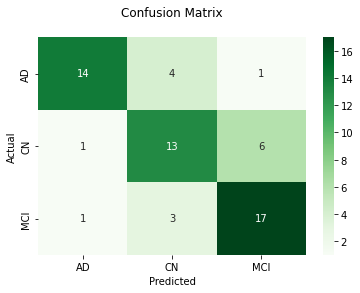

In [33]:
from sklearn.metrics import confusion_matrix
ConfusionMatrix = confusion_matrix(SVM_actual_label, SVM_pred_label)
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("Confusion Matrix\n")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report

In [34]:
from sklearn.metrics import classification_report
print(classification_report(SVM_actual_label, SVM_pred_label, target_names=["AD","CN","MCI"]))

              precision    recall  f1-score   support

          AD       0.88      0.74      0.80        19
          CN       0.65      0.65      0.65        20
         MCI       0.71      0.81      0.76        21

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.74        60
weighted avg       0.74      0.73      0.73        60



# Probabilities Testing

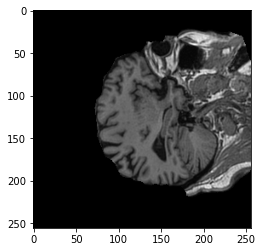

[[0.09439455 0.00249546 0.90310999]]
The actual label is 2
90.31 % chances are there that the image is MCI


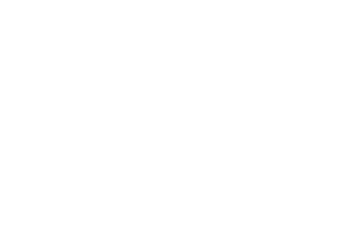

In [35]:
#TEST CASE 1
Test_image = valid_X[0]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
CNN_Result = model_features.predict(Test_image)
SVM_Result = SVM_Used.predict(CNN_Result)

print(SVM_Used.predict_proba(CNN_Result))

probability = round((maxProbability(SVM_Used.predict_proba(CNN_Result))*100),2)

print('The actual label is',SVM_actual_label[0])
if SVM_Result[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif SVM_Result[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif SVM_Result[0] == 2:
    print(probability, '% chances are there that the image is MCI')

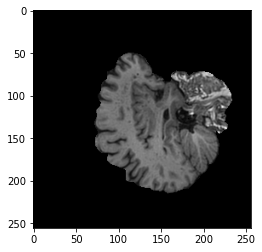

The actual label is 1
92.85 % chances are there that the image is CN


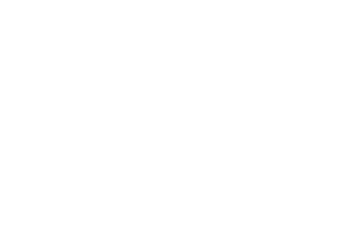

In [36]:
#TEST CASE 2
Test_image = valid_X[1]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
CNN_Result = model_features.predict(Test_image)
SVM_Result = SVM_Used.predict(CNN_Result)

probability = round((maxProbability(SVM_Used.predict_proba(CNN_Result))*100),2)

print('The actual label is',SVM_actual_label[1])
if SVM_Result[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif SVM_Result[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif SVM_Result[0] == 2:
    print(probability, '% chances are there that the image is MCI')

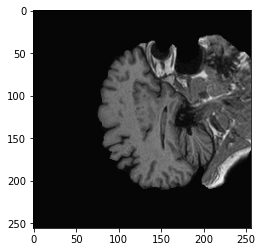

The actual label is 1
86.94 % chances are there that the image is CN


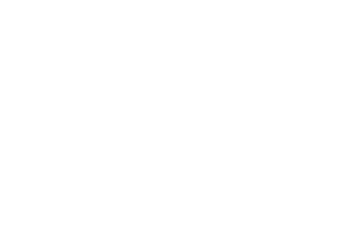

In [37]:
#TEST CASE 3
Test_image = valid_X[2]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
CNN_Result = model_features.predict(Test_image)
SVM_Result = SVM_Used.predict(CNN_Result)

probability = round((maxProbability(SVM_Used.predict_proba(CNN_Result))*100),2)

print('The actual label is',SVM_actual_label[2])
if SVM_Result[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif SVM_Result[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif SVM_Result[0] == 2:
    print(probability, '% chances are there that the image is MCI')

# SVM Poly

In [38]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

SVM_Poly_KFold= KFold(n_splits=10,shuffle=True,random_state=3)
svmPoly = SVC(kernel='poly')
hyperparameters= {'degree':[2,3,4],'C': [0.001, 0.1, 1, 10],'coef0':[1, 10]}
bestModelFound=GridSearchCV(svmPoly,hyperparameters,cv=SVM_Poly_KFold)
bestModelFound.fit(features_train,np.argmax(train_Y,axis=1))


bestDegree = bestModelFound.best_params_.get('degree')
print("The best degree is:",bestDegree)
bestC = bestModelFound.best_params_.get('C')
print("The best C is:",bestC)
bestDegree = bestModelFound.best_params_.get('degree')
print("The best degree is:",bestDegree)
bestCoef = bestModelFound.best_params_.get('coef0')
print("The best coef is:",bestCoef)
results= cross_val_score(SVC(kernel='poly',degree=bestDegree,C=bestC,coef0=bestCoef),features_train,np.argmax(train_Y,axis=1),cv=10)
print("The cross validation score is:",results)
print("The accuracy is :",results.mean()*100)

The best degree is: 4
The best C is: 0.1
The best degree is: 4
The best coef is: 10
The cross validation score is: [0.875      0.875      0.875      0.91666667 1.         0.91666667
 0.95833333 0.86956522 0.91304348 0.86956522]
The accuracy is : 90.68840579710144


In [39]:
SVM_Used_Poly =SVC(kernel='poly',degree=bestDegree,C=bestC,coef0=bestCoef,probability=True)
SVM_Used_Poly.fit(features_train,np.argmax(train_Y,axis=1))

SVC(C=0.1, coef0=10, degree=4, kernel='poly', probability=True)

# Prediction

In [40]:
SVM_Poly_pred_label = SVM_Used_Poly.predict(features_validate) #return learning labels 
SVM_Poly_actual_label=np.argmax(valid_Y,axis=1)

# Labelling

In [41]:
label_name=["AD","CN","MCI"]

# Confusion Matrix

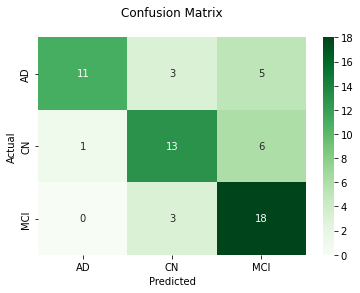

In [42]:
from sklearn.metrics import confusion_matrix

ConfusionMatrix = confusion_matrix(SVM_Poly_actual_label, SVM_Poly_pred_label)
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("Confusion Matrix\n")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report

In [43]:
from sklearn.metrics import classification_report
print(classification_report(SVM_Poly_actual_label, SVM_Poly_pred_label, target_names=["AD","CN","MCI"]))

              precision    recall  f1-score   support

          AD       0.92      0.58      0.71        19
          CN       0.68      0.65      0.67        20
         MCI       0.62      0.86      0.72        21

    accuracy                           0.70        60
   macro avg       0.74      0.70      0.70        60
weighted avg       0.74      0.70      0.70        60



# Probabilities Testing

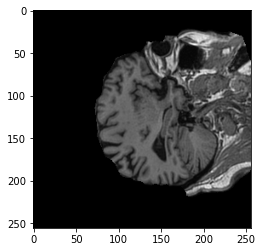

The actual label is 2
98.48 % chances are there that the image is MCI


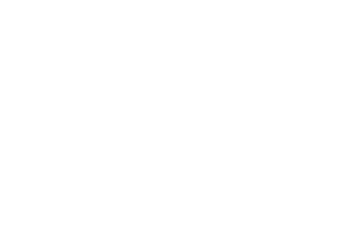

In [44]:

#TEST CASE 1
Test_image = valid_X[0]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
CNN_Result = model_features.predict(Test_image)
SVM_Result = SVM_Used_Poly.predict(CNN_Result)

probability = round((maxProbability(SVM_Used_Poly.predict_proba(CNN_Result))*100),2)

print('The actual label is',SVM_Poly_actual_label[0])
if SVM_Result[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif SVM_Result[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif SVM_Result[0] == 2:
    print(probability, '% chances are there that the image is MCI')

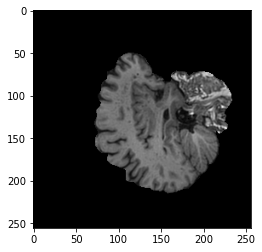

The actual label is 1
48.2 % chances are there that the image is MCI


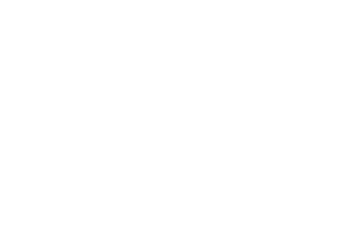

In [45]:
#TEST CASE 2
Test_image = valid_X[1]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
CNN_Result = model_features.predict(Test_image)
SVM_Result = SVM_Used_Poly.predict(CNN_Result)

probability = round((maxProbability(SVM_Used_Poly.predict_proba(CNN_Result))*100),2)

print('The actual label is',SVM_Poly_actual_label[1])
if SVM_Result[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif SVM_Result[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif SVM_Result[0] == 2:
    print(probability, '% chances are there that the image is MCI')

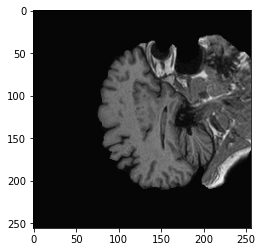

The actual label is 1
51.91 % chances are there that the image is CN


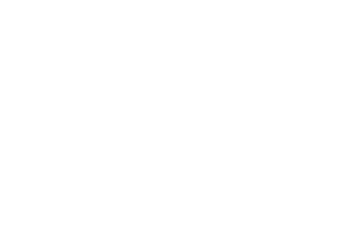

In [46]:
#TEST CASE 3
Test_image = valid_X[2]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
CNN_Result = model_features.predict(Test_image)
SVM_Result = SVM_Used_Poly.predict(CNN_Result)

probability = round((maxProbability(SVM_Used_Poly.predict_proba(CNN_Result))*100),2)

print('The actual label is',SVM_Poly_actual_label[2])
if SVM_Result[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif SVM_Result[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif SVM_Result[0] == 2:
    print(probability, '% chances are there that the image is MCI')

# XGBoost

In [47]:
import xgboost as xgb

xb = xgb.XGBClassifier()
xb.fit(features_train,np.argmax(train_Y,axis=1))


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

# Prediction

In [48]:
XGB_pred_label = xb.predict(features_validate) #return learning labels 
XGB_actual_label=np.argmax(valid_Y,axis=1)

# Labelling

In [49]:
label_name=["AD","CN","MCI"]

# Confusion Matrix

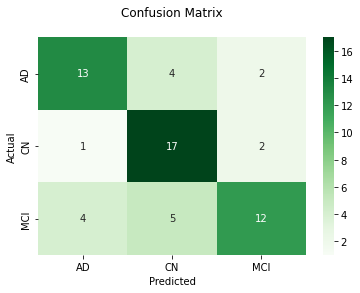

In [50]:
from sklearn.metrics import confusion_matrix

ConfusionMatrix = confusion_matrix(XGB_actual_label, XGB_pred_label)
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("Confusion Matrix\n")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report

In [51]:
from sklearn.metrics import classification_report
print(classification_report(XGB_actual_label, XGB_pred_label, target_names=["AD","CN","MCI"]))

              precision    recall  f1-score   support

          AD       0.72      0.68      0.70        19
          CN       0.65      0.85      0.74        20
         MCI       0.75      0.57      0.65        21

    accuracy                           0.70        60
   macro avg       0.71      0.70      0.70        60
weighted avg       0.71      0.70      0.70        60



# Probabilities Testing

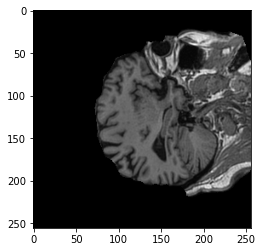

The actual label is 2
98.25 % chances are there that the image is MCI


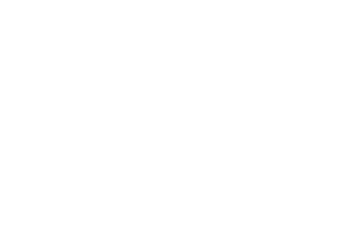

In [52]:
#TEST CASE 1
Test_image = valid_X[0]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
CNN_Result = model_features.predict(Test_image)
XGB_Result = xb.predict(CNN_Result)

probability = round((maxProbability(xb.predict_proba(CNN_Result))*100),2)

print('The actual label is',XGB_actual_label[0])
if XGB_Result[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif XGB_Result[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif XGB_Result[0] == 2:
    print(probability, '% chances are there that the image is MCI')

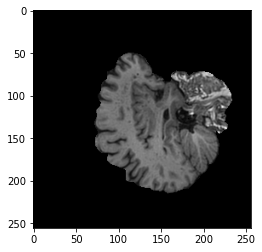

The actual label is 1
99.48 % chances are there that the image is CN


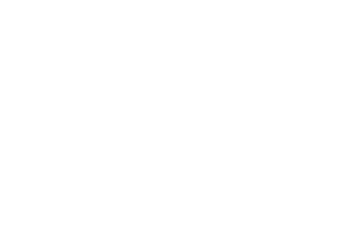

In [53]:
#TEST CASE 2
Test_image = valid_X[1]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
CNN_Result = model_features.predict(Test_image)
XGB_Result = xb.predict(CNN_Result)

probability = round((maxProbability(xb.predict_proba(CNN_Result))*100),2)

print('The actual label is',XGB_actual_label[1])
if XGB_Result[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif XGB_Result[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif XGB_Result[0] == 2:
    print(probability, '% chances are there that the image is MCI')

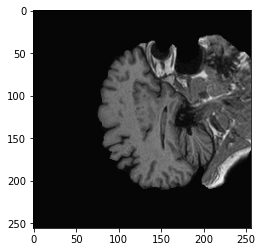

The actual label is 1
99.81 % chances are there that the image is CN


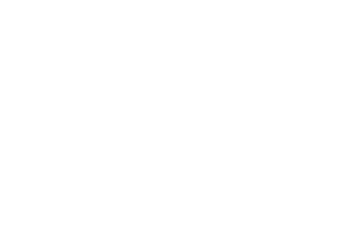

In [54]:
#TEST CASE 3
Test_image = valid_X[2]
plt.imshow(Test_image[110], cmap='gray')
plt.show()
plt.axis('off')

Test_image = np.expand_dims(Test_image, axis = 0)
CNN_Result = model_features.predict(Test_image)
XGB_Result = xb.predict(CNN_Result)

probability = round((maxProbability(xb.predict_proba(CNN_Result))*100),2)

print('The actual label is',XGB_actual_label[2])
if XGB_Result[0] == 0:
    print(probability, '% chances are there that the image is AD')
elif XGB_Result[0] == 1:
    print(probability, '% chances are there that the image is CN')
elif XGB_Result[0] == 2:
    print(probability, '% chances are there that the image is MCI')